In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

from HJK.dynamics.systems import simple2Dsystem
from HJK.basis import monomials

import cvxpy as cp

## Define the system dynamics

In [2]:
io_simple2D = ct.NonlinearIOSystem(
    simple2Dsystem, None, inputs=('u'), outputs=('x1', 'x2'),
    states=('x1', 'x2'), name='simple2D')

### Plot free response of the system

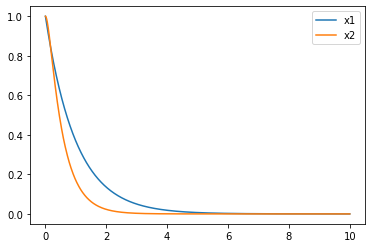

In [11]:
X0 = [1, 1]            
T = np.linspace(0, 10, 1000)   # Simulation 70 years of time
# Simulate the system
u = 0
params = {"mu":-1.0, "lam":-10.0}
t, y = ct.input_output_response(io_simple2D, T, u, X0, params)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['x1', 'x2'])
plt.show(block=False)

### Linearize the system

In [12]:
eqpt = ct.find_eqpt(io_simple2D, X0, 0)
xeq = eqpt[0]                         # choose the nonzero equilibrium point
lin_predprey = ct.linearize(io_simple2D, xeq, 0)
A = lin_predprey.A
B = lin_predprey.B

## Collect random datapoints from a domain

In [13]:
domain = 5
dim = 2
numIC = 1000
np.random.seed(1)
X = np.random.uniform(low=-domain, high=domain, size=(dim,numIC)).astype(float) 

## Generate basis functions
Monomials from d3s github

In [14]:
degree = 2
d3s_monomials = monomials.monomials(degree)
d3s_monomials.display(np.array([1.0, 1.0, 1.0, 1.0]),2)

1.000001 + 1.00000 x_1 + 1.00000 x_2 + 1.00000 x_1^2


In [15]:
Psi = d3s_monomials(X)
DPsi = d3s_monomials.diff(X)

# remove 1 and linear parts
Psi = Psi[dim+1:,:]
DPsi = DPsi[dim+1:,:]

## Setup Optimization problem

In [18]:
# get xdot values
t = 0
u = 0
F_z = y

# build gradient matrix grad_Psi * f(x)
Df_z = []
for i in range(numIC):
    Df_z.append(DPsi[:,:,i] @ F_z[:,i])
Df_z = np.array(Df_z).T

# get linear part
E = A
Ez = E @ X

# get observables and size
G_z = Psi
# get length of Psi to determine coefficient U dimensions
Nbs = np.shape(G_z)[0]

In [19]:
U = cp.Variable(shape=(dim, Nbs))
objective = cp.Minimize(cp.norm(U @ Df_z + F_z - A @ U @ G_z - Ez, 'fro'))
constraints  = []
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(U.value)

[[-0.01799053 -0.03492667  0.00192889]
 [-0.00335687 -0.00904743 -0.02560126]]
